# Consumer Behaviour Analysis

In this kernel we'll be building a Ticket Recommendation System for a cruise company using historical consumer data from https://techassessment.blob.core.windows.net/aiap15-assessment-data/cruise_pre.db and https://techassessment.blob.core.windows.net/aiap15-assessment-data/cruise_post.db Dataset. 

The user is able to input the attributes they are looking for when booking for a cruise ship. This input can be in the form of a questionnaire or by selecting specific attributes from a list. Given these x features, the model can predict the type of tickets potential customers are most likely to purchase.

In [1]:
# Import required libraries
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)  # To display all columns

**Importing dataset**
Next, we import the sqlite3 module and then create a connection object which will connect us to the database and will let us execute the SQL statements.
  > 1. sqlite3.connect(Database)
  > 2. read_sql_query: read SQL query into a dataframe
  > 3. Merge the two dataset using join on 'Ext_Intcode' feature

In [2]:
preDb_path, postDb_path = './data/cruise_pre.db' , './data/cruise_post.db'

# Read sqlite query results into a pandas DataFrame
preDb = pd.read_sql_query("SELECT * from cruise_pre", sqlite3.connect(preDb_path), index_col='index')
postDb = pd.read_sql_query("SELECT * from cruise_post", sqlite3.connect(postDb_path), index_col='index')

In [3]:
preDb.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode
index,,,,,,,,,,,,,,,,,,
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL


In [4]:
postDb.head(4)

,Cruise Name,Ticket Type,Cruise Distance,Ext_Intcode,WiFi,Dining,Entertainment
index,,,,,,,
0,Blastoise,None,3567 KM,LB446RWOOZI,1.0,1,1.0
1,Blastoise,Deluxe,672 KM,LB138HKBECM,NaN,0,1.0
2,IAPRAS,Deluxe,1167 KM,BL713UHBAAN,NaN,0,0.0
3,Lapras,Deluxe,280 KM,LB243DMKCFL,NaN,0,1.0


<b> Join the two dataframe using inner join</b>

In [5]:
# join the two dataframe using pd.merge()
df = pd.merge(preDb, postDb, on='Ext_Intcode')
df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,Somewhat important,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL,Lapras,Deluxe,280 KM,NaN,0,1.0


In [6]:
print(df.shape)

(141538, 24)


In summary, there is a total of 24 features, where 21 features are qualitative in nature and 3 quantitative features. Among the 21 qualitative features, a majority are ordinal data (13 features) from a likert scale while the rest are nominal. 
<div> 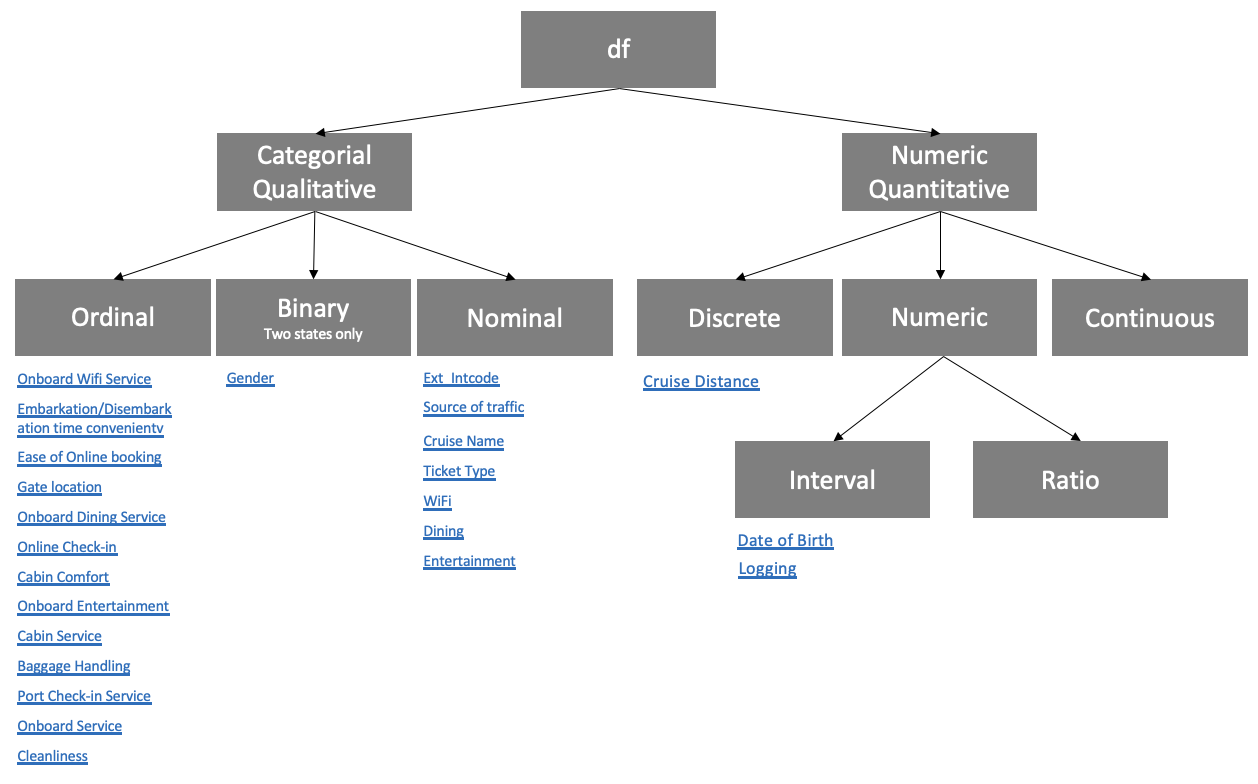 </div>

## Data Preprocessing

After gaining a basic understanding of the dataset such as the features, data types, and the number of rows and columns, the next step in the preprocessing pipeline is to process the data into a cleaner format such that meaningful information can be extracted. There are three phases of data preprocessing.

**Data Cleaning**
The first step of data preprocessing is data cleaning. This refers to the process of checking for missing or noisy data. During this step, we either drop or impute data. 
  > 1. Identify columns that contain a single value / delete columns that contain a single value
  > 2. Identify rows that contain duplicate data / delete rows that contain duplicate data
  > 3. Consider columns that have very few values
  > 4. Remove columns that have a low variance

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141538 entries, 0 to 141537
Data columns (total 24 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      127308 non-null  object 
 1   Date of Birth                               126056 non-null  object 
 2   Source of Traffic                           141538 non-null  object 
 3   Onboard Wifi Service                        120910 non-null  object 
 4   Embarkation/Disembarkation time convenient  125005 non-null  float64
 5   Ease of Online booking                      122047 non-null  float64
 6   Gate location                               123400 non-null  float64
 7   Logging                                     141538 non-null  object 
 8   Onboard Dining Service                      123793 non-null  object 
 9   Online Check-in                             124909 non-null  float64
 

In [8]:
for i in df.columns:
    num_missing = (df[[i]].isnull()).sum()
    perc = num_missing/df.shape[0]*100
    print('> %s, Missing: %d (%.1f%%)' % (i,num_missing.iloc[0],perc.iloc[0]))

> Gender, Missing: 14230 (10.1%)
> Date of Birth, Missing: 15482 (10.9%)
> Source of Traffic, Missing: 0 (0.0%)
> Onboard Wifi Service, Missing: 20628 (14.6%)
> Embarkation/Disembarkation time convenient, Missing: 16533 (11.7%)
> Ease of Online booking, Missing: 19491 (13.8%)
> Gate location, Missing: 18138 (12.8%)
> Logging, Missing: 0 (0.0%)
> Onboard Dining Service, Missing: 17745 (12.5%)
> Online Check-in, Missing: 16629 (11.7%)
> Cabin Comfort, Missing: 24621 (17.4%)
> Onboard Entertainment, Missing: 16845 (11.9%)
> Cabin service, Missing: 14588 (10.3%)
> Baggage handling, Missing: 24669 (17.4%)
> Port Check-in Service, Missing: 15149 (10.7%)
> Onboard Service, Missing: 19479 (13.8%)
> Cleanliness, Missing: 22714 (16.0%)
> Ext_Intcode, Missing: 0 (0.0%)
> Cruise Name, Missing: 16901 (11.9%)
> Ticket Type, Missing: 21256 (15.0%)
> Cruise Distance, Missing: 15304 (10.8%)
> WiFi, Missing: 73780 (52.1%)
> Dining, Missing: 0 (0.0%)
> Entertainment, Missing: 63569 (44.9%)


From the dataset information, besides 'Source of Traffic', 'Logging', 'Ext_Intcode' and 'Dining', there are missing data in the remaining features. Among these missing features, 'WiFi' and 'Entertainment' has the most number of missing entries, with 52% and 45% entries missing. Meanwhile, remaining attributes has 10 to 15% missing data. With these information, **check 'Entertainment' and 'WiFi' feature**.

In [9]:
# Check 'Entertainment' feature; show entries containing null values
null_df = df[df['Entertainment'].isnull()]
null_df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS,Lapras,Standard,1145 Miles,NaN,1,NaN
5,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS,Lapras,Standard,1145 Miles,NaN,1,NaN
6,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:11,Not at all important,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,LB218CFLOBS,Lapras,Standard,1145 Miles,NaN,1,NaN
7,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:11,Not at all important,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,LB218CFLOBS,Lapras,Standard,1145 Miles,NaN,1,NaN


We can identify that some entries are duplicates. Handle all duplicates by dropping until one unique entry is left

In [10]:
df = df.drop_duplicates(keep='first')

In [11]:
ent_null_df = df[df['Entertainment'].isnull()]
ent_null_df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,Not at all important,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS,Lapras,Standard,1145 Miles,NaN,1,NaN
6,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:11,Not at all important,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,LB218CFLOBS,Lapras,Standard,1145 Miles,NaN,1,NaN
8,Male,23/12/1986,Direct - Email Marketing,Somewhat important,5.0,3.0,3.0,01/01/2023 0:11,Very important,NaN,4.0,Very important,NaN,4.0,3.0,4.0,4.0,BL115AWWXPU,Lapras,Standard,607 KM,NaN,1,NaN
9,Male,20/03/1987,Indirect - Social Media,Very important,1.0,4.0,4.0,01/01/2023 0:12,A little important,NaN,2.0,A little important,2.0,4.0,4.0,NaN,2.0,LB313ANTIPC,Blastoise,None,528 KM,NaN,1,NaN


In [12]:
# duplicates are removed
df.head(3)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,WiFi,Dining,Entertainment
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,Very important,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1.0,1,1.0
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,Very important,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,NaN,0,1.0
2,Female,22/07/1998,Indirect - Search Engine,None,3.0,0.0,5.0,01/01/2023 0:02,None,NaN,5.0,Extremely important,2.0,1.0,2.0,3.0,NaN,BL713UHBAAN,IAPRAS,Deluxe,1167 KM,NaN,0,0.0


In [13]:
satisfied_scale_mapper = {0 : 'Not satisfied', 1 : 'Satisfied'}

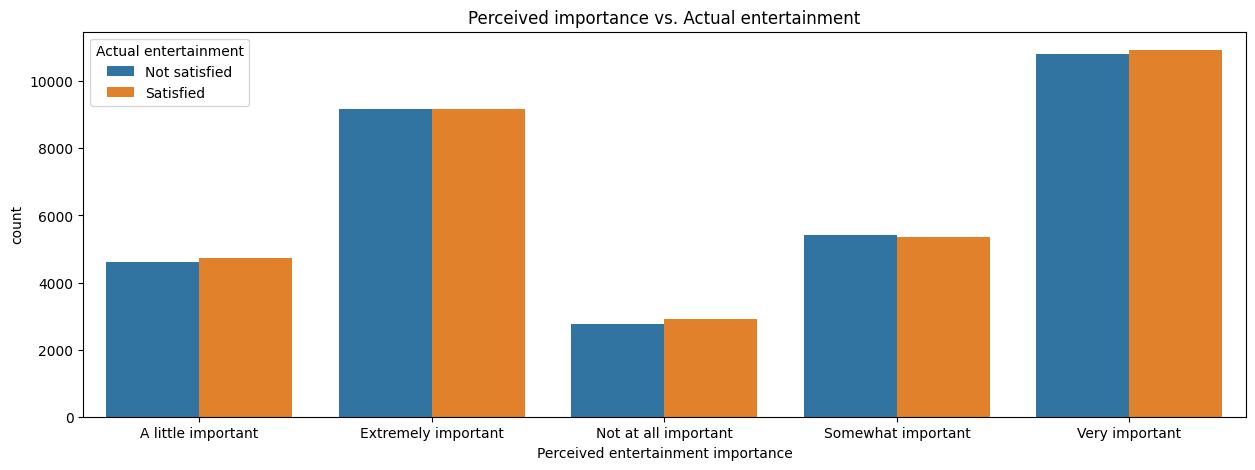

In [14]:
# Entertainment
ent_df = pd.DataFrame({'count' : df.groupby(['Entertainment','Onboard Entertainment']).size()}).reset_index()
ent_df['Entertainment'] = ent_df['Entertainment'].replace(satisfied_scale_mapper)
plt.subplots(figsize = (15,5))
sns.barplot(data=ent_df, x='Onboard Entertainment', y='count', hue='Entertainment')
plt.title("Perceived importance vs. Actual entertainment")
plt.legend(title='Actual entertainment', loc='upper left')
plt.xlabel('Perceived entertainment importance')
plt.show()

If both 'Onboard Entertainment' and 'Entertainment' attributes have the same variance relationship, it suggests that they provide redundant information, and we can consider dropping one of them. Redundant features can lead to multicollinearity in statistical models and might not add any value to your analysis. **Since 'Entertainment' has more missing values than 'Onboard Entertainment': Drop 'Entertainment'**

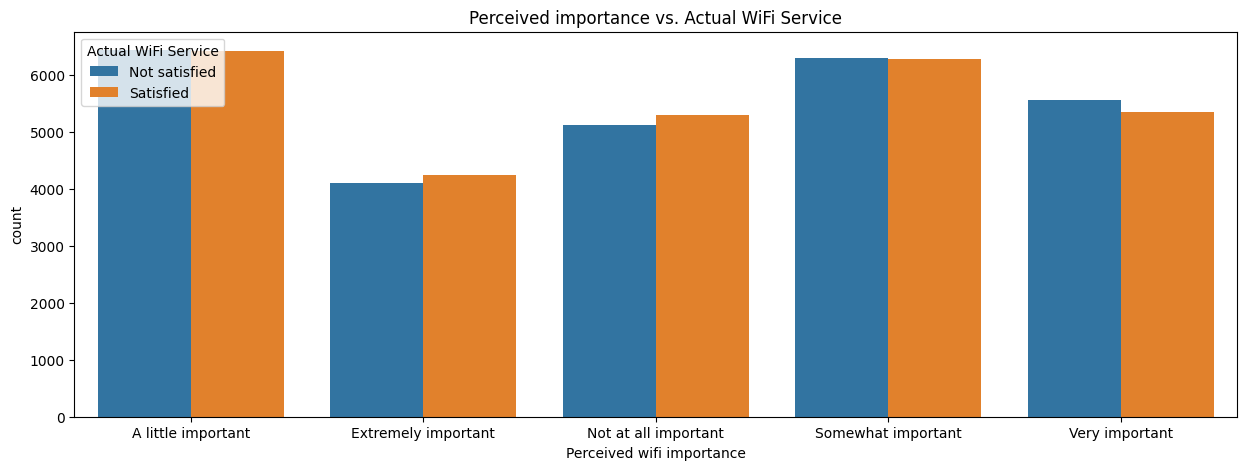

In [15]:
# Wifi
wifi_df = pd.DataFrame({'count' : df.groupby(['WiFi','Onboard Wifi Service']).size()}).reset_index()
wifi_df['WiFi'] = wifi_df['WiFi'].replace(satisfied_scale_mapper)
plt.subplots(figsize = (15,5))
sns.barplot(data=wifi_df, x='Onboard Wifi Service', y='count', hue='WiFi')
plt.title("Perceived importance vs. Actual WiFi Service")
plt.legend(title='Actual WiFi Service', loc='upper left')
plt.xlabel('Perceived wifi importance')
plt.show()

A similar relationship is observed in both 'Onboard Wifi Service' and 'WiFi' attributes. **Since 'WiFi' has more missing values than 'Onboard Wifi Service': Drop 'WiFi'**

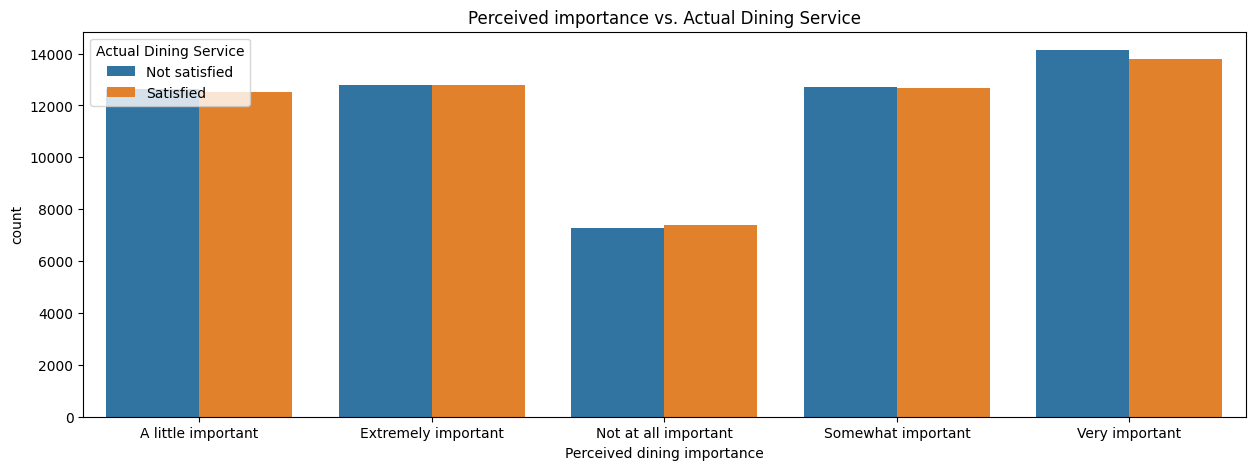

In [16]:
# Dining
dine_df = pd.DataFrame({'count' : df.groupby(['Dining','Onboard Dining Service']).size()}).reset_index()
dine_df['Dining'] = dine_df['Dining'].replace(satisfied_scale_mapper)
plt.subplots(figsize = (15,5))
sns.barplot(data=dine_df, x='Onboard Dining Service', y='count', hue='Dining')
plt.title("Perceived importance vs. Actual Dining Service")
plt.legend(title='Actual Dining Service', loc='upper left')
plt.xlabel('Perceived dining importance')
plt.show()

A similar relationship is observed in both 'Onboard Dining Service' and 'Dining' attributes. **Since 'Onboard Dining Service' has more missing values than 'Dining': Drop 'Onboard Dining Service '**

In [17]:
# Drop both WiFi, Entertainment, Onboard Dining Service features
df.drop(columns='WiFi', inplace=True)
df.drop(columns='Entertainment', inplace=True)
df.drop(columns='Onboard Dining Service', inplace=True)

Next, check rows that do not contain the target value 'Ticket Type'. Since the total number of missing entries is 15% of the dataset. it is still acceptable and **Drop entries where 'Ticket Type' is NULL**

In [18]:
tix_null_df = df[df['Ticket Type'].isnull()]
tix_null_df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,Dining
0,None,05/10/1973,Direct - Company Website,A little important,3.0,5.0,3.0,01/01/2023 0:00,2.0,2.0,A little important,2.0,2.0,4.0,2.0,3.0,LB446RWOOZI,Blastoise,None,3567 KM,1
9,Male,20/03/1987,Indirect - Social Media,Very important,1.0,4.0,4.0,01/01/2023 0:12,NaN,2.0,A little important,2.0,4.0,4.0,NaN,2.0,LB313ANTIPC,Blastoise,None,528 KM,1
26,Female,01/01/1982,Direct - Email Marketing,Not at all important,5.0,5.0,NaN,01/01/2023 0:41,1.0,1.0,None,2.0,3.0,NaN,3.0,NaN,BL292CJMJDH,Blastoise,None,-158 KM,0
40,Female,10/05/1978,Direct - Email Marketing,Not at all important,1.0,5.0,1.0,01/01/2023 1:13,3.0,1.0,Extremely important,5.0,4.0,5.0,5.0,1.0,LB462UMAIWD,None,None,201 KM,0


In [19]:
df.dropna(subset=['Ticket Type'], inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 114710 entries, 1 to 141537
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      103194 non-null  object 
 1   Date of Birth                               102101 non-null  object 
 2   Source of Traffic                           114710 non-null  object 
 3   Onboard Wifi Service                        98028 non-null   object 
 4   Embarkation/Disembarkation time convenient  101318 non-null  float64
 5   Ease of Online booking                      98925 non-null   float64
 6   Gate location                               99965 non-null   float64
 7   Logging                                     114710 non-null  object 
 8   Online Check-in                             101329 non-null  float64
 9   Cabin Comfort                               96934 non-null   float64
 10  O

Check if ordinal data values corresponds to likert scale response (1-5) values. The minimimum values for ordinal data is 1 while maximum value is 5.

In [21]:
df.describe()

,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Dining
count,101318.000000,98925.000000,99965.000000,101329.000000,96934.000000,102848.000000,96939.000000,102427.000000,98917.000000,98536.000000,114710.000000
mean,3.057334,2.757018,2.978643,3.248695,3.437628,3.384859,3.632552,3.306892,3.641538,3.285946,0.501046
std,1.525558,1.400568,1.277874,1.351515,1.321314,1.286879,1.178018,1.268093,1.178281,1.313687,0.500001
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000
50%,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,1.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


There are features that contain more than 5 unique values. As such, we check all unique values in each feature. 0 is present in the data when it is not present on the response values. These features includes:
1. Embarkation/Disembarkation time convenient
2. Ease of Online booking' 
3. Gate location
4. Online Check-in
5. Cabin Comfort
6. Cabin service
7. Onboard Service
8. Cleanliness

In [22]:
rangeCheck = pd.concat([df.iloc[:, 8:10],df.iloc[:, 11],df.iloc[:, 14:16],df.iloc[:, 4:7]], axis=1)
for i in rangeCheck.columns:
    zero_count = rangeCheck[rangeCheck[i]==0.0].shape[0]
    perc = zero_count/df[i].shape[0]*100
    print('> %s, "0" response : %d (%.1f%%)' % (i,zero_count,perc))

> Online Check-in, "0" response : 2399 (2.1%)
> Cabin Comfort, "0" response : 1 (0.0%)
> Cabin service, "0" response : 4 (0.0%)
> Onboard Service, "0" response : 4 (0.0%)
> Cleanliness, "0" response : 13 (0.0%)
> Embarkation/Disembarkation time convenient, "0" response : 5164 (4.5%)
> Ease of Online booking, "0" response : 4298 (3.7%)
> Gate location, "0" response : 1 (0.0%)


With minimal incorrect response values, **drop entries that has response value of 0**.

In [23]:
for col in rangeCheck.columns:
    df = df[(df[col] != 0.0)]
    rangeCheck = rangeCheck[(rangeCheck[col] != 0.0)]

In [24]:
df.describe()

,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Online Check-in,Cabin Comfort,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Dining
count,93675.000000,91690.000000,92846.000000,94021.000000,90009.000000,95514.000000,90005.000000,95101.000000,91837.000000,91470.000000,106486.000000
mean,3.205466,2.875886,2.987108,3.325895,3.451699,3.388268,3.637642,3.297011,3.645796,3.293211,0.500573
std,1.387605,1.299887,1.281565,1.266068,1.314612,1.285296,1.167431,1.267795,1.168775,1.310326,0.500002
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000,3.000000,2.000000,0.000000
50%,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,1.000000
75%,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,5.000000,4.000000,1.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 106486 entries, 1 to 141536
Data columns (total 21 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   Gender                                      95817 non-null   object 
 1   Date of Birth                               94743 non-null   object 
 2   Source of Traffic                           106486 non-null  object 
 3   Onboard Wifi Service                        93515 non-null   object 
 4   Embarkation/Disembarkation time convenient  93675 non-null   float64
 5   Ease of Online booking                      91690 non-null   float64
 6   Gate location                               92846 non-null   float64
 7   Logging                                     106486 non-null  object 
 8   Online Check-in                             94021 non-null   float64
 9   Cabin Comfort                               90009 non-null   float64
 10  O

In [26]:
df.head(4)

,Gender,Date of Birth,Source of Traffic,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Logging,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,Baggage handling,Port Check-in Service,Onboard Service,Cleanliness,Ext_Intcode,Cruise Name,Ticket Type,Cruise Distance,Dining
1,Female,None,Indirect - Social Media,Not at all important,4.0,1.0,NaN,01/01/2023 0:01,NaN,4.0,None,2.0,3.0,4.0,4.0,4.0,LB138HKBECM,Blastoise,Deluxe,672 KM,0
3,Female,01/05/1970,Direct - Company Website,Very important,4.0,4.0,4.0,01/01/2023 0:05,4.0,4.0,None,NaN,NaN,3.0,2.0,4.0,LB243DMKCFL,Lapras,Deluxe,280 KM,0
4,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:06,2.0,NaN,Not at all important,3.0,NaN,5.0,2.0,NaN,LB218CFLOBS,Lapras,Standard,1145 Miles,1
6,Male,07/01/1960,Direct - Company Website,Somewhat important,4.0,2.0,NaN,01/01/2023 0:11,2.0,1.0,Not at all important,3.0,3.0,5.0,2.0,1.0,LB218CFLOBS,Lapras,Standard,1145 Miles,1


With missing data in the dataset, perform possible imputation of data by analyzing demographic and infer their preference values if necessary. 

**Data Transformation**
The second step of data preprocessing is data transformation. This includes:

 > 1. Data normalization: min-max normalization/z-score normalization.
 > 2. Data aggregation
 > 3. Data smoothing
 > 4. Data discretization
 > 5. Data encoding
 > 6. Attribute construction 